In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.selectors import *

from hermes3.utils import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

In [3]:
toload = [ 
    # dict(name="base", id="upst1ai-strumpack_Tnorm_x10_match_fluxlim", unnormalise = True), 
    # dict(name="new", id="upst5a-reimplement_AFN_from_upst1ah", unnormalise = True), 
    # dict(name="base", id="upst5a-new_ena_hflim1_maxmfp_0.1_multispecies_econd", unnormalise = True), 
    # dict(name="Nnorm_x10", id="upst5ab-Nnorm_x10", unnormalise = True), 
    dict(name="brag", id="upst5bxx-braginskii_everything_found_steady_slowdown", unnormalise = True), 
    
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = False, verbose = True, unnormalise = case["unnormalise"], unnormalise_geom = case["unnormalise"])
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case upst5bxx-braginskii_everything_found_steady_slowdown
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# Max and RMS fluctuations

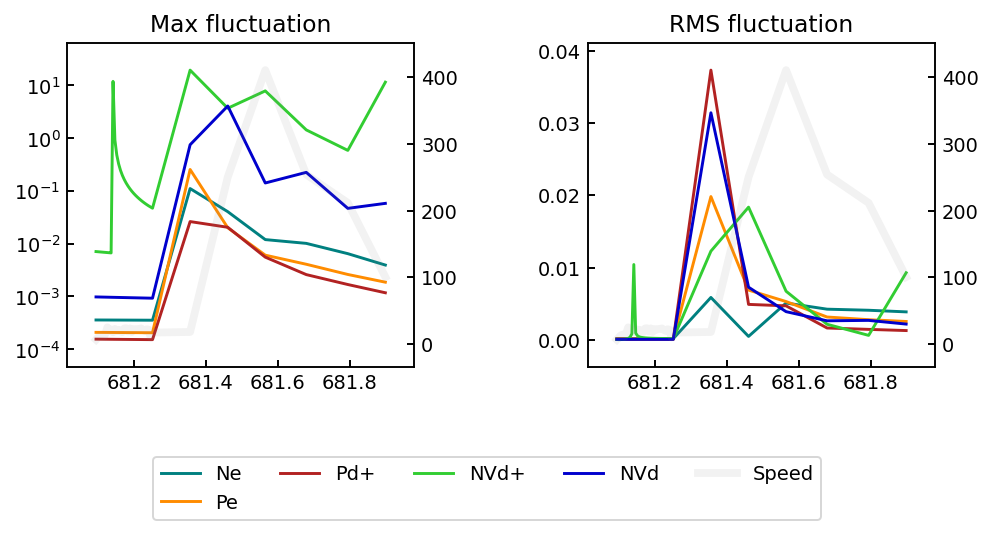

In [18]:
name = "brag"
ds = cs[name].ds

t = ds["t"] * 1000
stime = np.diff(t, prepend = t[0]*0.99)
ms_per_24hrs = (stime) / (ds["wtime"]/(60*60*24))  # ms simulated per 24 hours

params = ["Ne", "Pe", "Pd+", "NVd+", "NVd"]
# params = ["NVd+"]

fig, axes = plt.subplots(1, 2, figsize = (8, 3))

for i, param in enumerate(params):
    
    data = ds[param].values + 1e-10
    diff = np.diff(data, axis=0, prepend=0) / data

    diff_max = np.max(diff, axis=(1,2))
    diff_rms = np.sqrt(np.mean(diff, axis=(1,2))**2)


    speed_style = dict(c = "grey", alpha = 0.1, lw = 4, label = "speed")

    # t = ds["t"].values
    ax = axes[0]
    ax.set_title("Max fluctuation")
    ax.plot(t[1:], diff_max[1:],  label = param)
    ax.set_yscale("log")

    
    # t = ds["t"].values
    ax = axes[1]
    ax.set_title("RMS fluctuation")
    ax.plot(t[1:], diff_rms[1:])


speed_style = dict(c = "grey", alpha = 0.1, lw = 4)
    
for i, ax in enumerate(axes):
    ax2 = ax.twinx()
    if i == 0:
        label = "Speed"
    else:
        label = ""
    ax2.plot(t[1:], ms_per_24hrs[1:], **speed_style, label = label)
    
fig.subplots_adjust(wspace = 0.5)
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.1), ncols = 5)


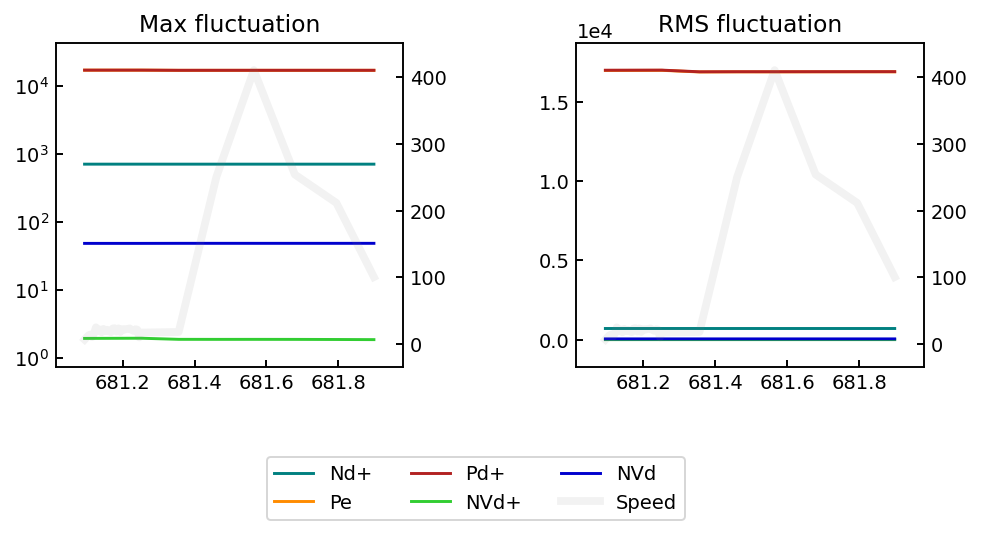

In [17]:
name = "brag"
ds = cs[name].ds

t = ds["t"] * 1000
stime = np.diff(t, prepend = t[0]*0.99)
ms_per_24hrs = (stime) / (ds["wtime"]/(60*60*24))  # ms simulated per 24 hours

params = ["Nd+", "Pe", "Pd+", "NVd+", "NVd"]
# params = ["NVd+"]

fig, axes = plt.subplots(1, 2, figsize = (8, 3))

for i, param in enumerate(params):
    
    
    ddt = ds[f"ddt({param})"] + 1e-10
    ddt = ddt / ddt.attrs["conversion"]
    ddt = ddt.values
    
    data = ds[param] + 1e-10
    data = data / data.attrs["conversion"]
    data = data.values
    
    diff = ddt
    diff_max = np.mean(diff, axis = (1,2))
    # diff_max = np.max(diff, axis=(1,2))
    diff_rms = np.sqrt(np.mean(diff, axis=(1,2))**2)

    # t = ds["t"].values
    ax = axes[0]
    ax.set_title("Max fluctuation")
    ax.plot(t[1:], diff_max[1:],  label = param)
    ax.set_yscale("log")
    
    # t = ds["t"].values
    ax = axes[1]
    ax.set_title("RMS fluctuation")
    ax.plot(t[1:], diff_rms[1:])

speed_style = dict(c = "grey", alpha = 0.1, lw = 4)
    
for i, ax in enumerate(axes):
    ax2 = ax.twinx()
    if i == 0:
        label = "Speed"
    else:
        label = ""
    ax2.plot(t[1:], ms_per_24hrs[1:], **speed_style, label = label)
    
fig.subplots_adjust(wspace = 0.5)
fig.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.1), ncols = 3)


# Fluctuation 2D plots

In [ ]:
plot_fluctuations(cs["brag"].ds, ["Pe", "Pd", "Nd+", "Nd", "Te", "Td", "NVd+", "NVd"], mode = "rel_variable_rms", ylims = (-0.85, 0.1))

# Fluctuation animation

In [ ]:
plt.close("all")

fig, ax = plt.subplots(figsize = (3,9))

name = "brag"

ds = cs[name].ds
xbout.plotting.animate.animate_poloidal(
    ds["NVd+"].hermesm.clean_guards(), 
    ax = ax, 
    cmap = "Spectral_r", 
    fps = 5, 
    targets = False,
    logscale = True,
    vmin = -1e-3,
    vmax =  1e-3
    )

In [7]:
ds["t"].values[-7]

np.float64(0.6812511943022755)

AttributeError: 'numpy.float64' object has no attribute 'items'

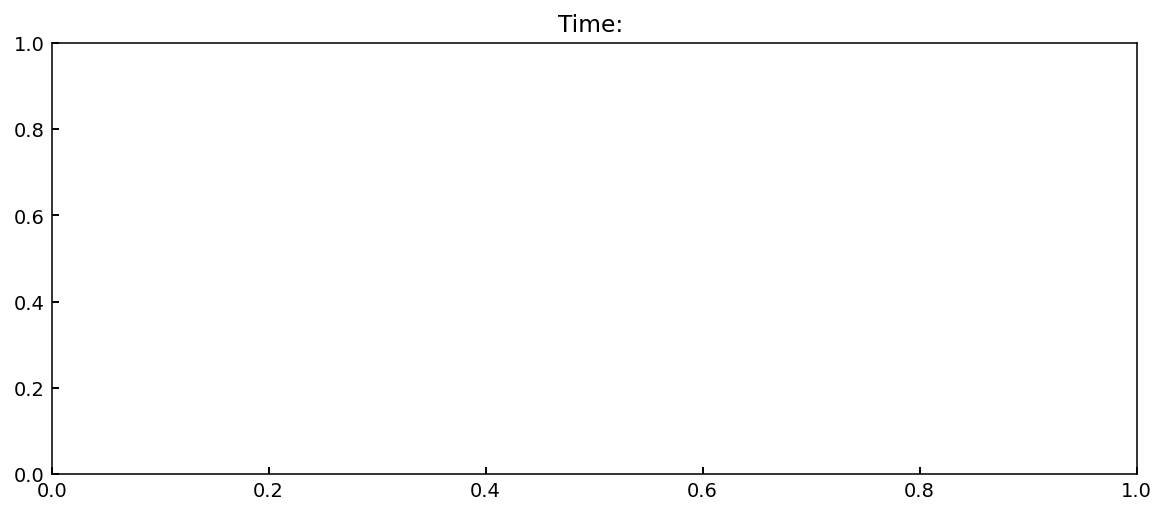

In [8]:

data = ds["Pe"].hermesm.clean_guards()
diff = data.diff(dim="t") / data
da = diff

x = ds["x"].values
theta = ds["theta"].values

# ensure orientation is (theta, x)
tind = -7
C0 = da.isel(t=tind).values

fig, ax = plt.subplots(figsize=(10,4))
ax.set_title("Time: ", ds["t"].values[tind])
pcm = ax.pcolormesh(theta, x, C0, shading="auto", cmap="Spectral_r")
fig.colorbar(pcm, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("theta")



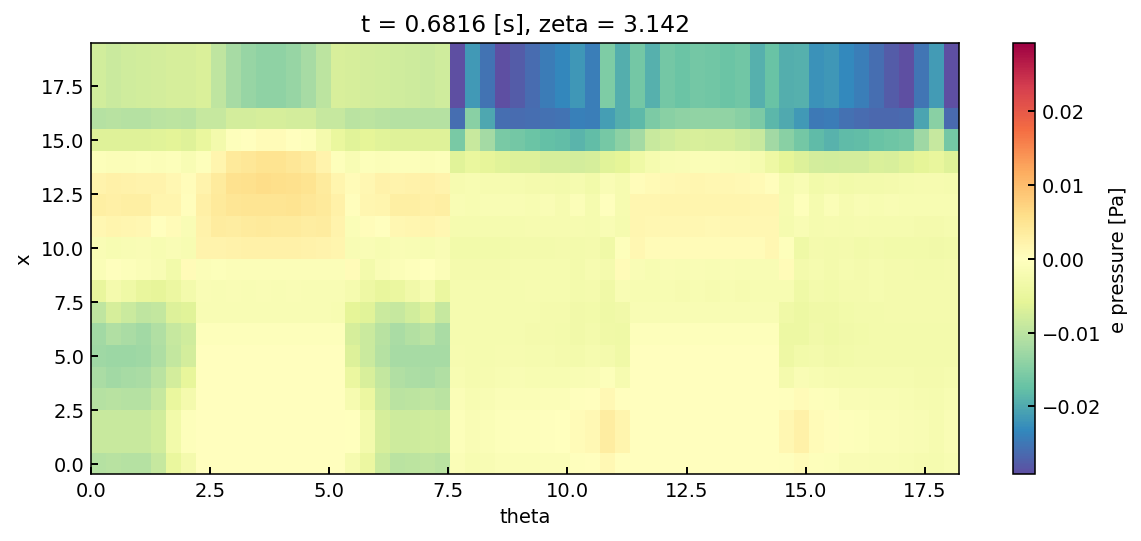

In [ ]:

fig, ax = plt.subplots(figsize = (10,4))
diff.isel(t=-4).plot(ax = ax, cmap = "Spectral_r")

In [ ]:
# --- Plot setup ---
fig, ax = plt.subplots(figsize = (10,4))

pcm = ax.pcolormesh(x, y, da.isel(t=0), shading="auto")
fig.colorbar(pcm, ax=ax)

def update(frame):
    pcm.set_array(da.isel(t=frame).values.ravel())
    ax.set_title(f"t = {da.t.values[frame]:.2f}")
    return pcm,

ani = FuncAnimation(fig, update, frames=len(time), interval=100, blit=True)
plt.show()

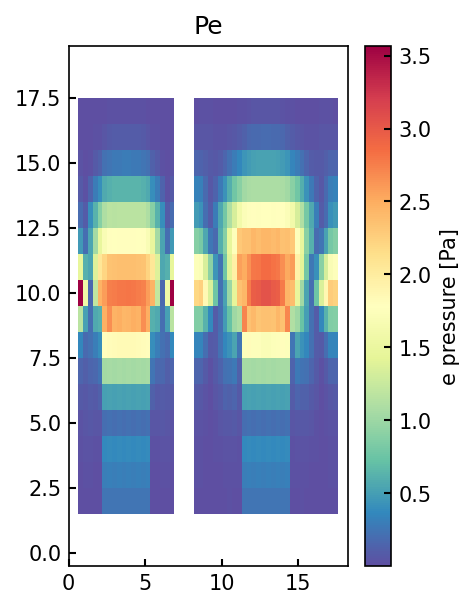

In [ ]:


cmap = "Spectral_r"

name = "brag"

ds = cs[name].ds
params = ["Nd+", "Nd", "Pe", "Pd+", "Pd", "NVd+", "NVd"]

params = ["Pe"]

no_params = len(params)
fig, axes = plt.subplots(1,no_params, figsize = (3.0*no_params,4.5), dpi = 150)
if no_params == 1:
  axes = [axes]

for i, param in enumerate(params):
  
  da_param = ds[param]
  ddt_param = ds[f"ddt({param})"]
  if "t" in ds.sizes:
    # fluctuations = np.sqrt((ds[ddt_param]**2).mean(dim="t"))
    
    diff = da_param.diff(dim="t")
    reldiff = diff/da_param
    rms = np.sqrt((diff**2).mean(dim="t"))

  else:
    print("WARNING: NO TIME!")

  data = rms
  
  ax = axes[i]
  # data.hermesm.clean_guards().bout.polygon(ax = ax, cmap = cmap, targets = False, 
  #                                                       separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 0),
  #                                                       antialias = False,
  #                                                       logscale = False,
  #                                                       # vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
  #                                                       )
  data.hermesm.clean_guards().plot(ax = ax, cmap = cmap)
  ax.set_title(param)
  ax.set_xlabel("")
  ax.set_ylabel("")

In [ ]:
np.set_printoptions(threshold=np.inf)
data.values

In [42]:
if "t" in ds.sizes: ds = ds.isel(t=-1)

# da = ds["Pe"]
da = data
bad_mask = (da.isnull() | (da < 0)).compute()
bad = da.where(bad_mask, drop=True)   # keeps coords of offending points

bad.values
# da.where(da < 0).compute().values.dropna()
# ds["Pe"].isnull()

array([], shape=(0, 0, 0), dtype=float64)

In [4]:
%matplotlib widget

In [5]:
cs.keys()

dict_keys(['brag'])

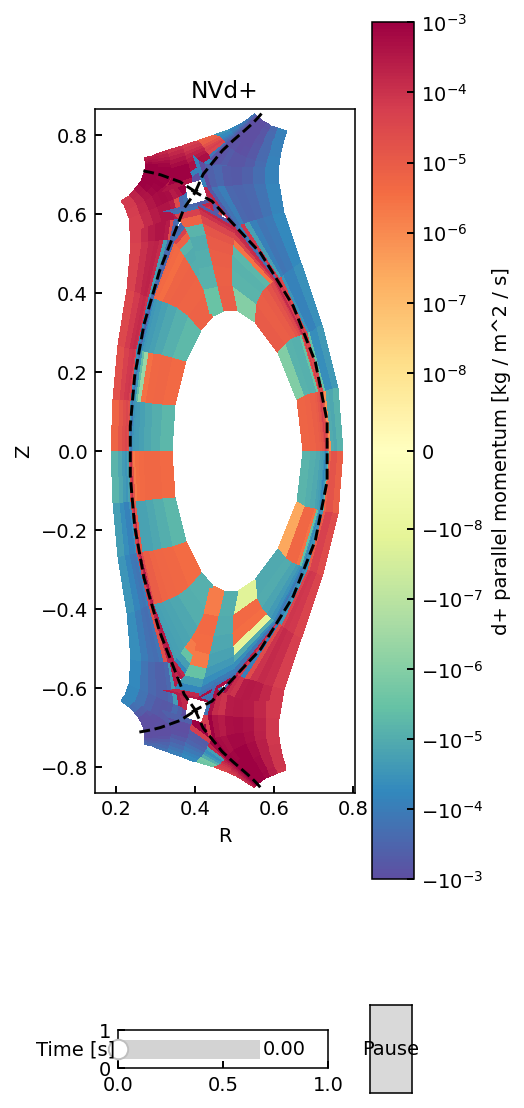

In [17]:
plt.close("all")

fig, ax = plt.subplots(figsize = (3,9))

name = "brag"

ds = cs[name].ds
xbout.plotting.animate.animate_poloidal(
    ds["NVd+"].hermesm.clean_guards(), 
    ax = ax, 
    cmap = "Spectral_r", 
    fps = 5, 
    targets = False,
    logscale = True,
    vmin = -1e-3,
    vmax =  1e-3
    )

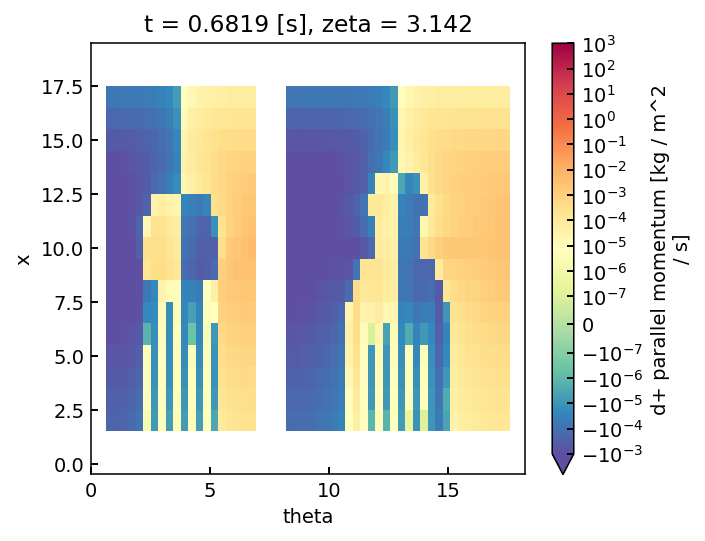

In [53]:
fig, ax = plt.subplots()

norm = create_norm(True, None, -1e-3, 1e3, linthresh = 1e-7)

ds["NVd+"].hermesm.clean_guards().isel(t=-1).plot( 
    ax = ax, 
    cmap = "Spectral_r", 
    norm = norm
    )

(-0.85, 0.05)

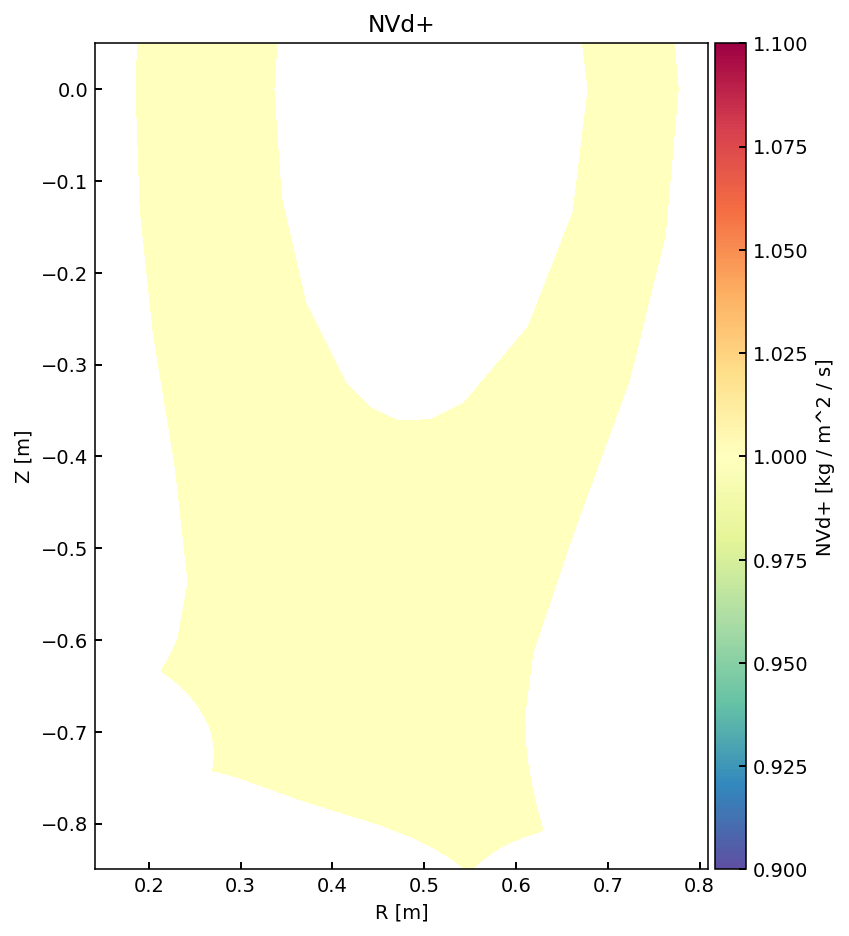

In [70]:
plt.close("all")

fig, ax = plt.subplots(figsize = (6,12))

name = "brag"

ds = cs[name].ds.isel(t=-1)

data = ds["NVd+"].diff(dim = "t") / ds["NVd+"]


data.hermesm.clean_guards().bout.polygon( 
    ax = ax, 
    cmap = "Spectral_r", 
    targets = False,
    logscale = False,
    separatrix = False,
    # vmin = -1e-3,
    # vmax =  1e-3
    )
    
ax.set_ylim(-0.85, 0.05)


In [31]:
%matplotlib inline

Text(0.5, 1.0, 'Ion momentum in 1st core ring')

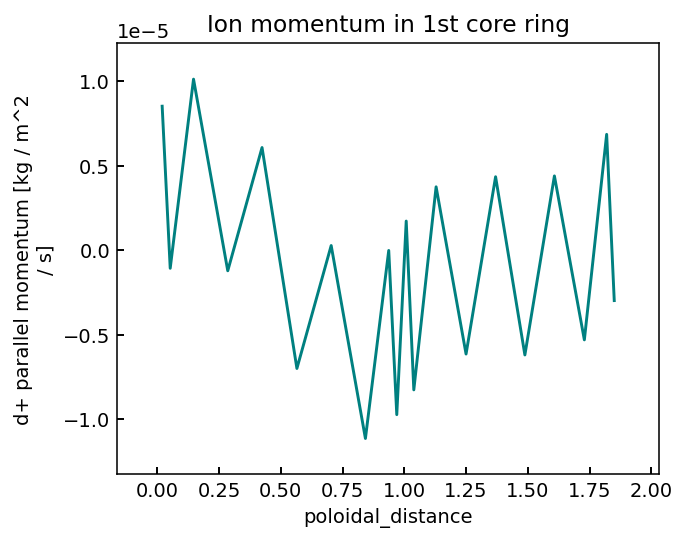

In [59]:
fig, ax = plt.subplots()

core = ds.hermesm.select_custom_core_ring(0).isel(t=0)

# ax.plot(core["theta"], core["NVd+"].squeeze())
core["NVd+"].plot(ax = ax, x = "poloidal_distance")
ax.set_title("Ion momentum in 1st core ring")

Object `plot` not found.


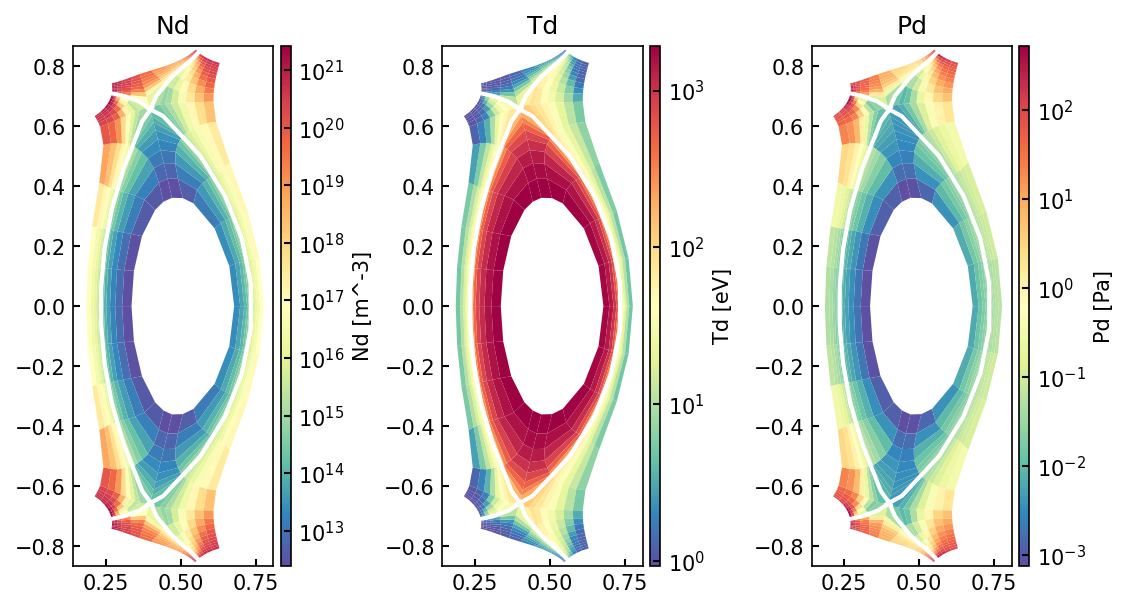

In [26]:
fig, axes = plt.subplots(1,3, figsize = (3.0*3,4.5), dpi = 150)
cmap = "Spectral_r"

name = "Nnorm_x10"

ds = cs[name].ds
if "t" in ds.sizes: ds = ds.isel(t=-1)

for i, param in enumerate(["Nd", "Td", "Pd"]):
  
  data = ds[param]
  ax = axes[i]
  data.hermesm.clean_guards().bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                        # colorbar_label="Test",
                                                        antialias = True,
                                                        logscale = True,
                                                        # vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                        )
  ax.set_title(param)
  ax.set_xlabel("")
  ax.set_ylabel("")